# Skin cancer image classification

the dataset would be downloaded throught kaggle, to complete this step i had download my kaggle API and upload it to the google colab note book i am using. The next step was to create a folder named kaggle and set the security preference. after doing this step we can download the *ISIC 2018 skin legion dataset* and unzip it. the dataset contains other folders like it's metadata and is 5gb large.

In [1]:
# !pip install kaggle

In [2]:
# !mkdir ~/.kaggle

In [3]:
# !cp kaggle.json ~/.kaggle/

In [4]:
# !chmod 600 ~/.kaggle/kaggle.json

In [5]:
# ! kaggle datasets download kmader/skin-cancer-mnist-ham10000

In [6]:
# !unzip skin-cancer-mnist-ham10000.zip

## Loading in libraries and path

In [7]:
# a = []
# while(1):
#   a.append('i')

In [8]:
import os
from glob import glob
import pandas as pd
from skimage.io import imread
import matplotlib.pyplot  as plt
from PIL import Image
from pathlib import Path
import imagesize
import numpy as np

base_dir = os.path.join('../skin-legion-deep-learning-project-/')

In [9]:
import tensorflow as tf
import tensorflow_hub as hub
print('Tf-version:', tf.__version__)

print("GPU","Yes Available" if tf.test.is_gpu_available() else "not Available")

Tf-version: 2.10.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Yes Available
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-11-15 02:11:55.961094: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-15 02:11:55.962298: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [11]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [12]:
tile_df = pd.read_csv(os.path.join(base_dir, 'HAM10000_metadata.csv'))
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get) 
tile_df['path'] = tile_df['image_id'].map(imageid_path_dict.get)
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes
tile_df.sample(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,cell_type_idx
1293,HAM_0001203,ISIC_0025081,mel,histo,30.0,female,abdomen,Melanoma,../skin-legion-deep-learning-project-/HAM10000...,5
8530,HAM_0005664,ISIC_0029001,nv,histo,45.0,male,abdomen,Melanocytic nevi,../skin-legion-deep-learning-project-/HAM10000...,4
9248,HAM_0006936,ISIC_0031829,nv,consensus,15.0,female,chest,Melanocytic nevi,../skin-legion-deep-learning-project-/HAM10000...,4


In [13]:
tile_df['cell_type'].unique()

array(['Benign keratosis-like lesions ', 'Melanocytic nevi',
       'Dermatofibroma', 'Melanoma', 'Vascular lesions',
       'Basal cell carcinoma', 'Actinic keratoses'], dtype=object)

In [14]:
# load in all of the images
tile_df['image'] = tile_df['path'].map(imread)

In [15]:
# see the image size distribution
tile_df['image'].map(lambda x: x.shape).value_counts()

(450, 600, 3)    10015
Name: image, dtype: int64

In [16]:
tile_df[['cell_type_idx', 'cell_type']].sort_values('cell_type_idx').drop_duplicates()

,cell_type_idx,cell_type
9804,0,Actinic keratoses
2528,1,Basal cell carcinoma
1018,2,Benign keratosis-like lesions
1159,3,Dermatofibroma
7050,4,Melanocytic nevi
1622,5,Melanoma
2413,6,Vascular lesions


In [17]:
tile_df['image'] = tile_df['path'].map(lambda x: np.asarray(Image.open(x).resize((224,224))))

## converting the size of the image dataset

because the dataset is 450 in height and 600 in width and in RGB format, i would like to downscale the size to help in reducing training time on the GPU

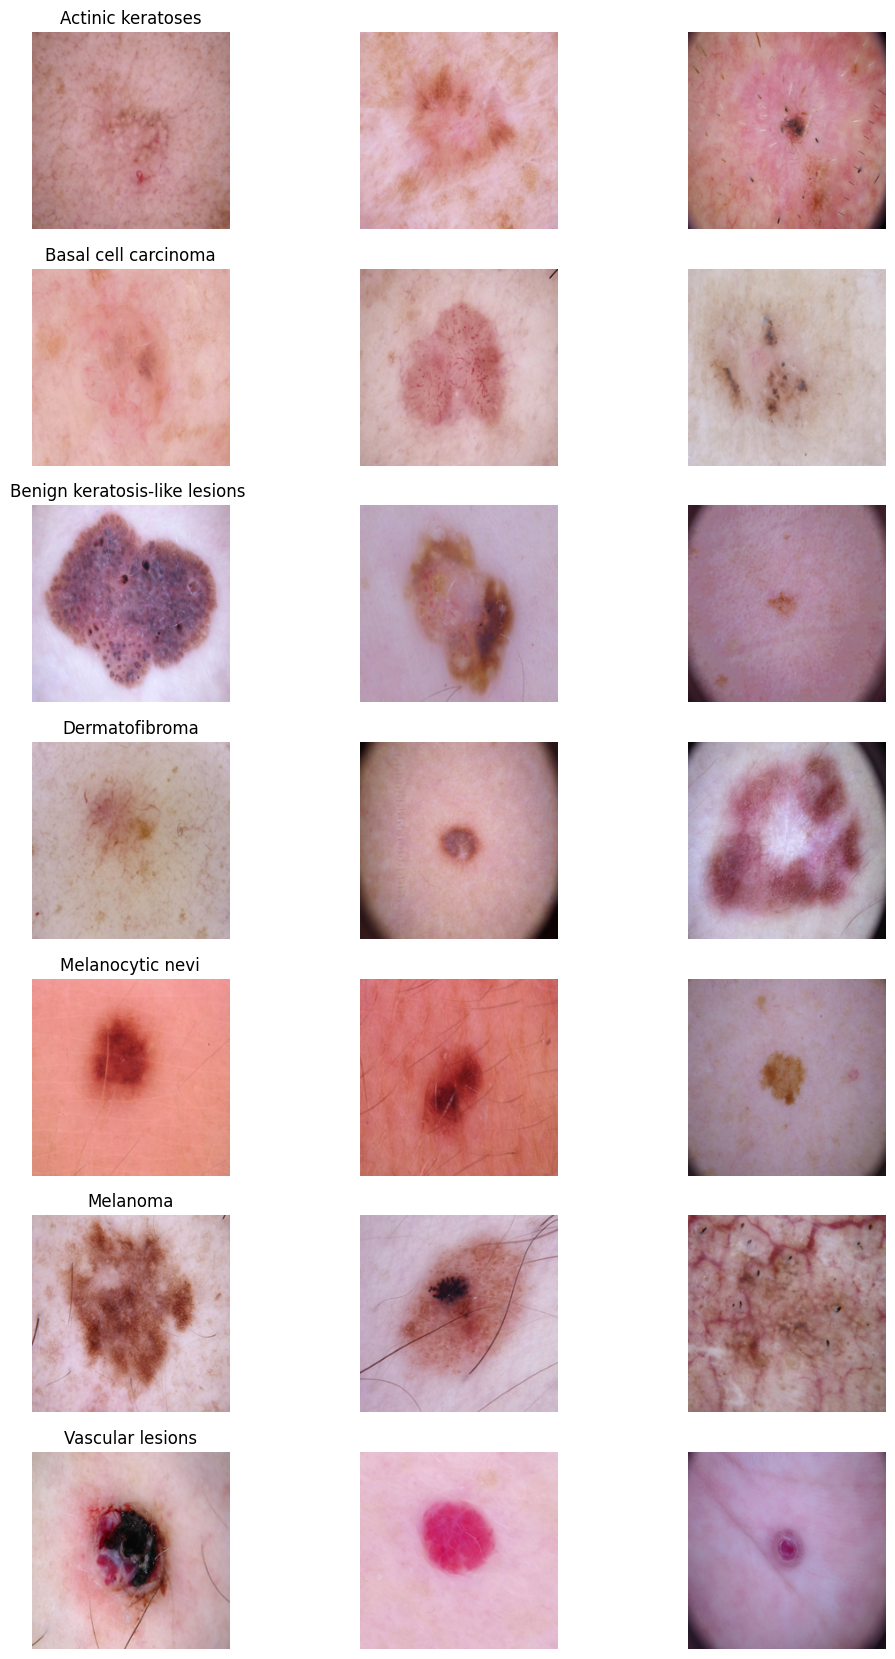

In [18]:
n_samples = 3
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         tile_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=42).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [19]:
# See the image size distribution - should just return one row (all images are uniform)
tile_df['image'].map(lambda x: x.shape).value_counts()

(224, 224, 3)    10015
Name: image, dtype: int64

In [20]:
tile_df.head(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,../skin-legion-deep-learning-project-/HAM10000...,2,"[[[187, 150, 192], [190, 154, 195], [192, 156,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,../skin-legion-deep-learning-project-/HAM10000...,2,"[[[24, 13, 22], [25, 13, 23], [24, 14, 23], [2..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,../skin-legion-deep-learning-project-/HAM10000...,2,"[[[186, 127, 135], [188, 129, 137], [191, 135,..."


In [21]:
tile_df.dtypes

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
cell_type         object
path              object
cell_type_idx       int8
image             object
dtype: object

In [22]:
tile_df.describe()

,age,cell_type_idx
count,9958.000000,10015.000000
mean,51.863828,3.623964
std,16.968614,1.208859
min,0.000000,0.000000
25%,40.000000,4.000000
50%,50.000000,4.000000
75%,65.000000,4.000000
max,85.000000,6.000000


# DATA CLEANING

In [23]:
tile_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
cell_type         0
path              0
cell_type_idx     0
image             0
dtype: int64

<AxesSubplot: >

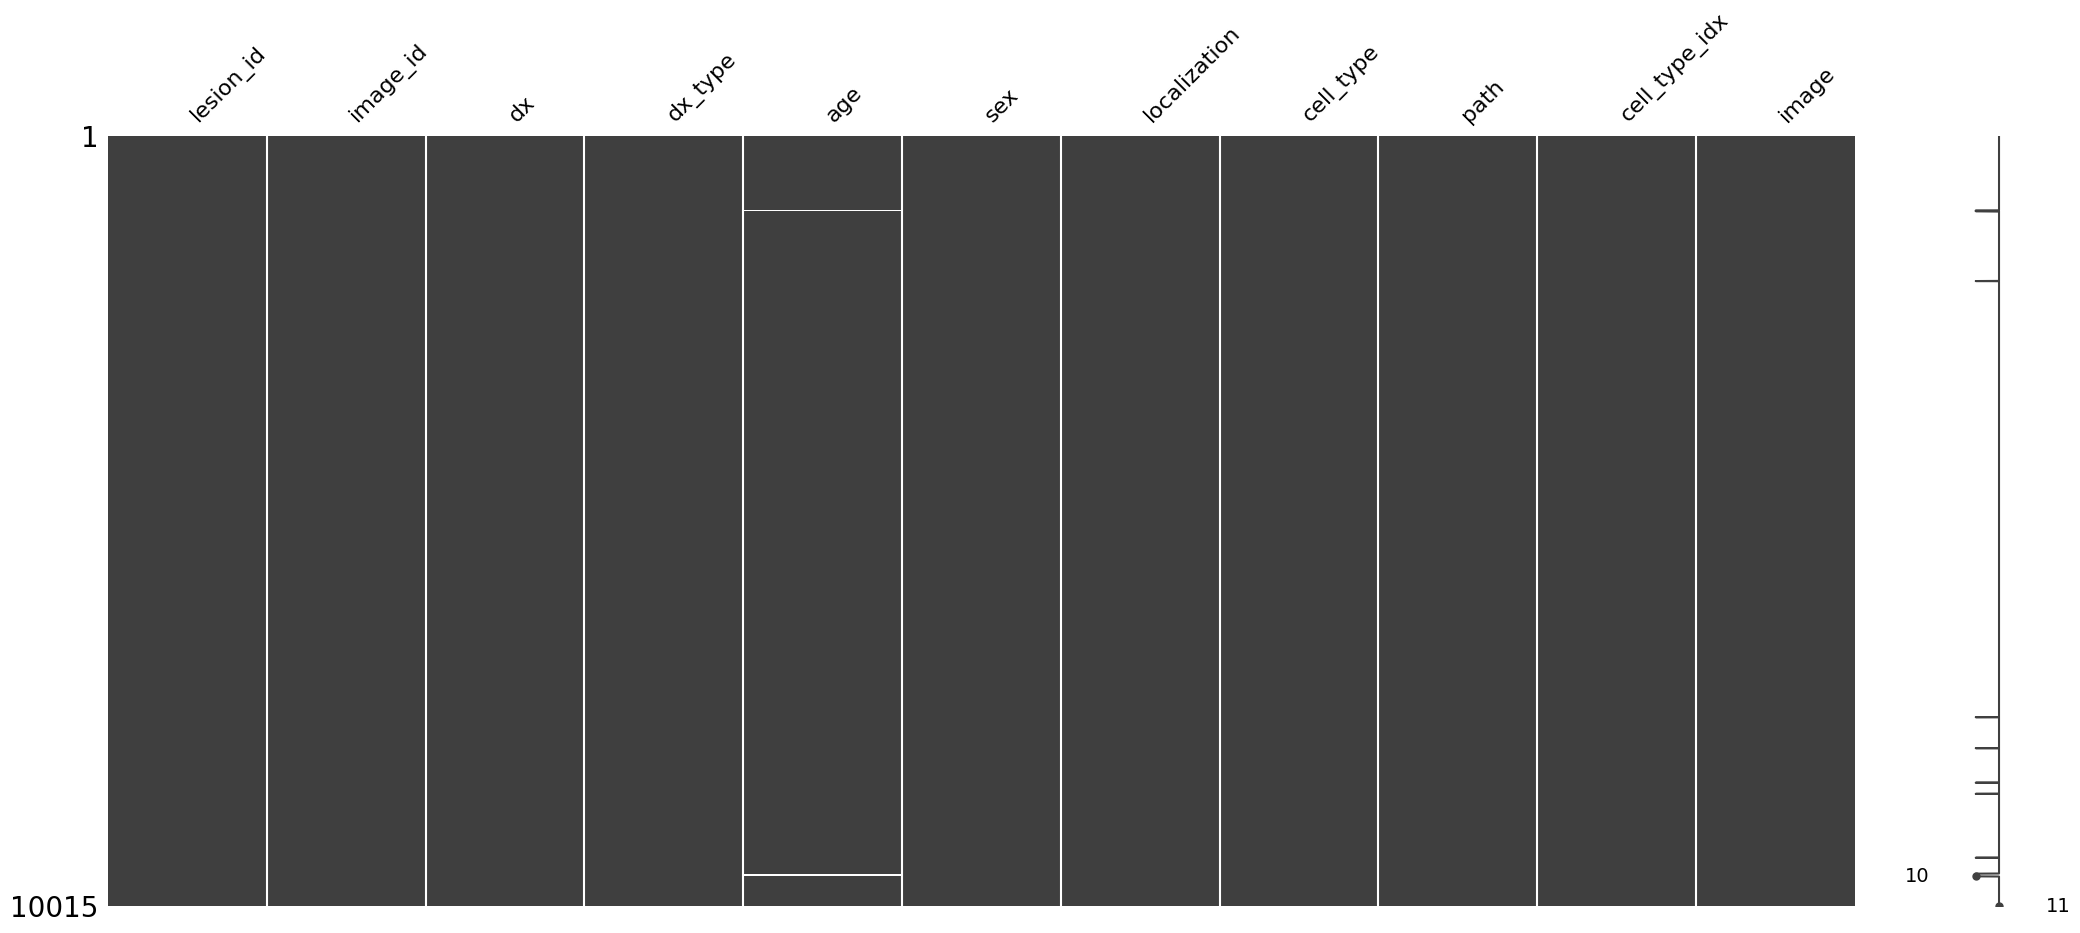

In [24]:
import missingno as msno
msno.matrix(tile_df)

In [25]:
tile_df['age'].fillna(int(tile_df['age'].mean()),inplace=True)

In [26]:
tile_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
cell_type        0
path             0
cell_type_idx    0
image            0
dtype: int64

# UNIVARIATE ANALYSIS

<AxesSubplot: title={'center': 'CELL TYPE'}, ylabel='Count'>

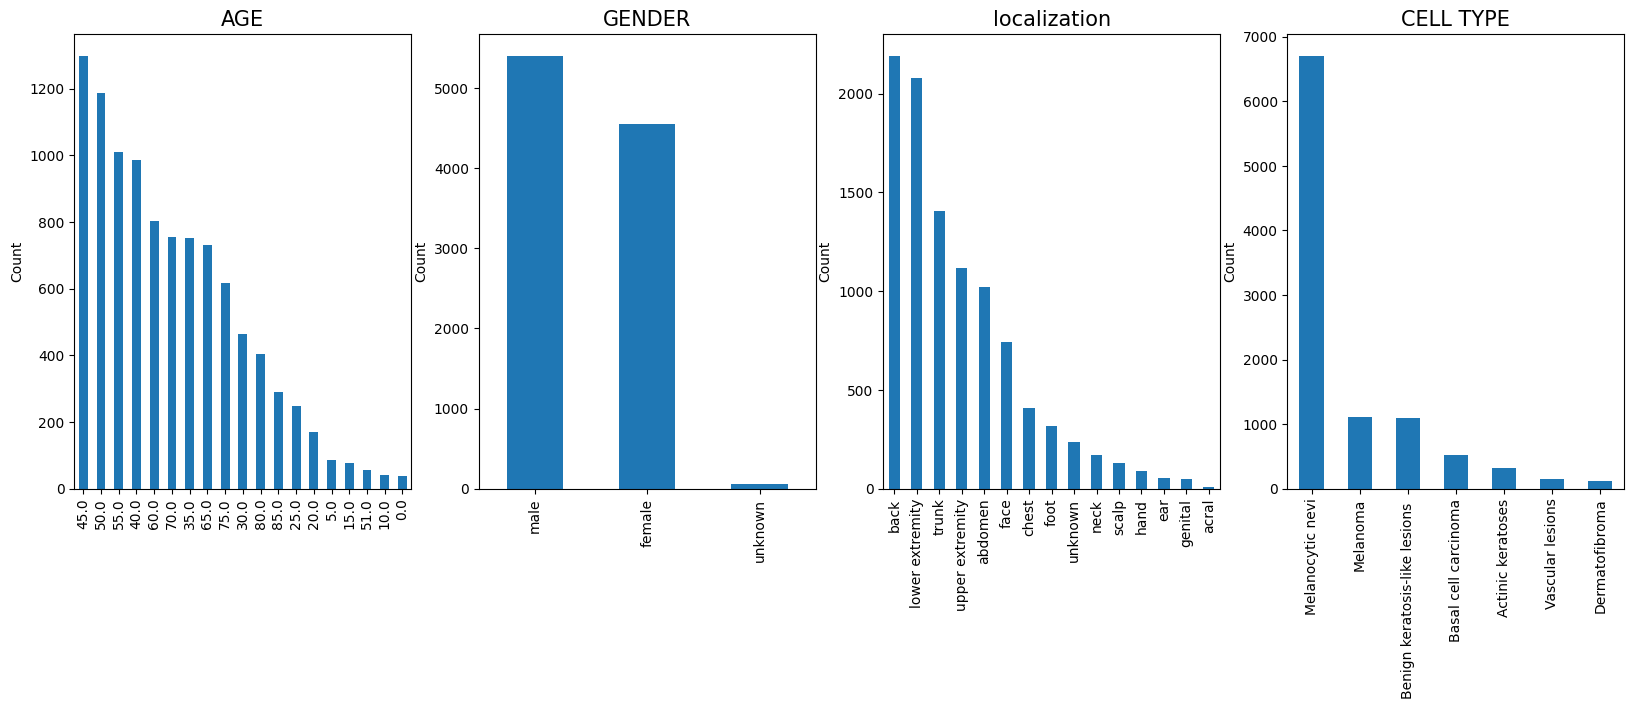

In [27]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(left=0.125, bottom=1, right=0.9, top=2, hspace=0.2)
plt.subplot(2,4,1)
plt.title("AGE",fontsize=15)
plt.ylabel("Count")
tile_df['age'].value_counts().plot.bar()

plt.subplot(2,4,2)
plt.title("GENDER",fontsize=15)
plt.ylabel("Count")
tile_df['sex'].value_counts().plot.bar()

plt.subplot(2,4,3)
plt.title("localization",fontsize=15)
plt.ylabel("Count")
plt.xticks(rotation=45)
tile_df['localization'].value_counts().plot.bar()

plt.subplot(2,4,4)
plt.title("CELL TYPE",fontsize=15)
plt.ylabel("Count")
tile_df['cell_type'].value_counts().plot.bar()

In [28]:
import seaborn as sns

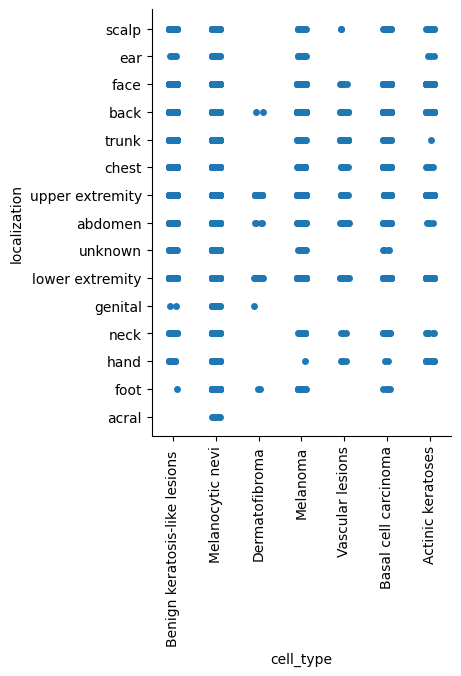

In [29]:
a=sns.catplot(data=tile_df, x="cell_type", y="localization")
a.set_xticklabels(rotation=90)

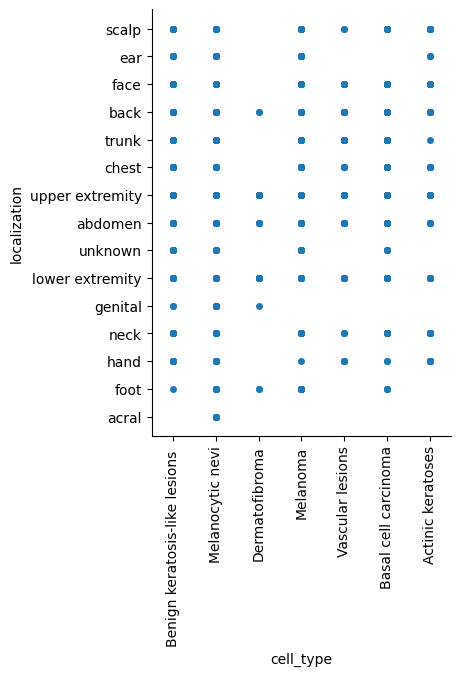

In [30]:
b=sns.catplot(data=tile_df, x="cell_type", y="localization", jitter=False)
b.set_xticklabels(rotation=90)

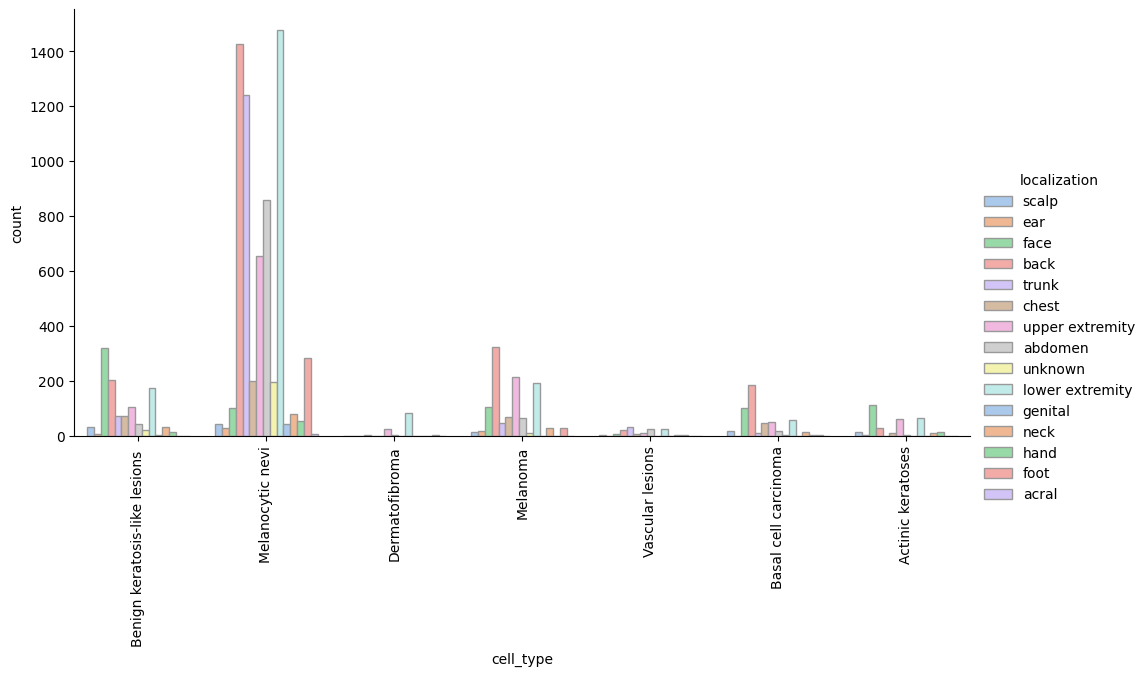

In [31]:
sns.catplot(
    data=tile_df, x="cell_type", hue="localization", kind = 'count',
    palette="pastel", edgecolor=".6",height=5, aspect=10/5
).set_xticklabels(rotation=90)


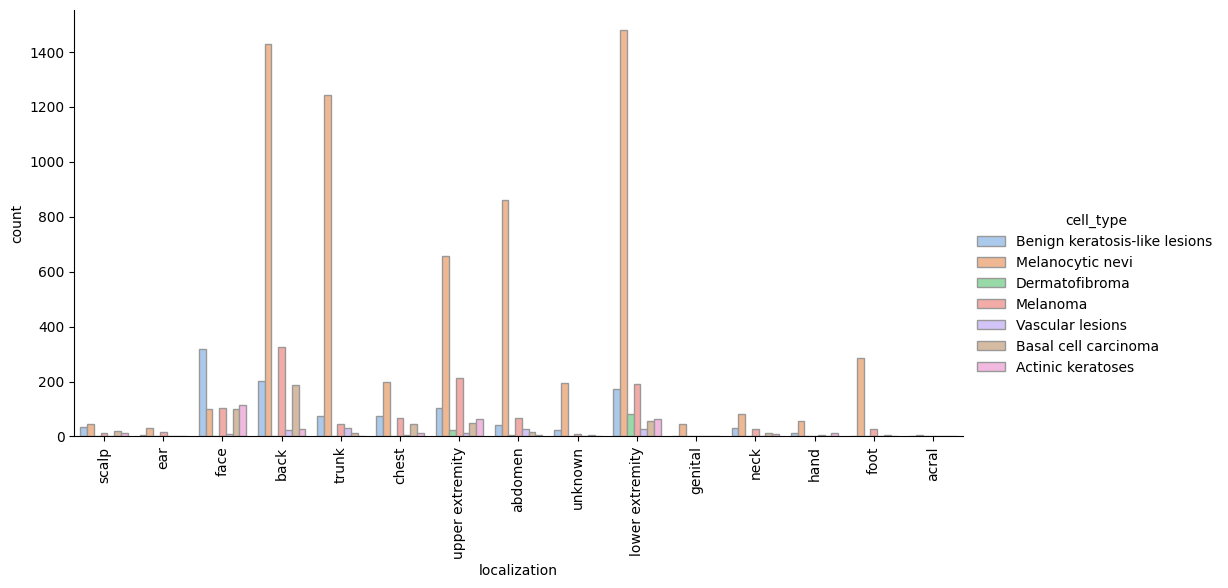

In [32]:
sns.catplot(
    data=tile_df, x="localization", hue="cell_type", kind = 'count',
    palette="pastel", edgecolor=".6",height=5, aspect=10/5
).set_xticklabels(rotation=90)

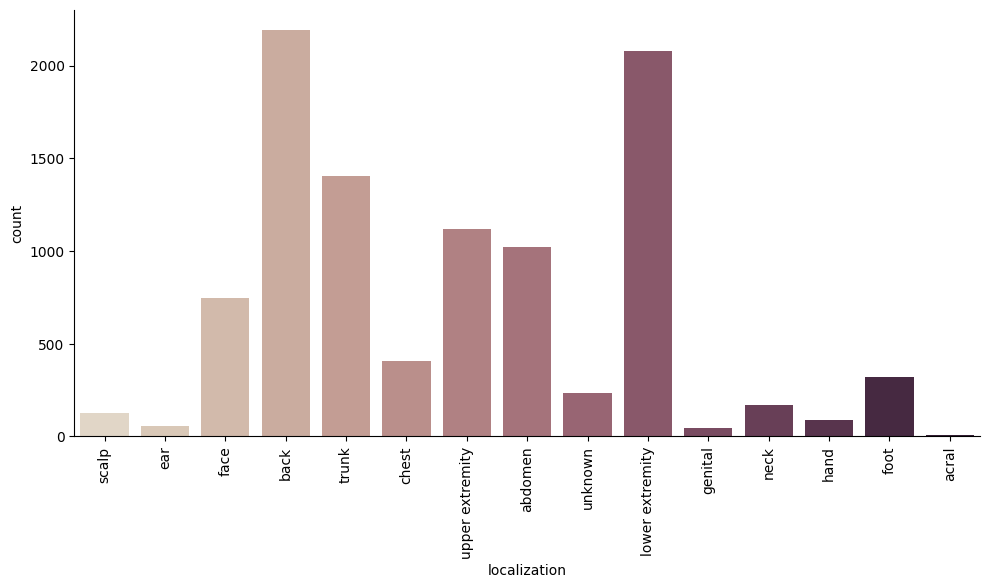

In [33]:

sns.catplot(data=tile_df, x="localization", kind="count", palette="ch:.25", height=5, aspect=10/5).set_xticklabels(rotation=90)

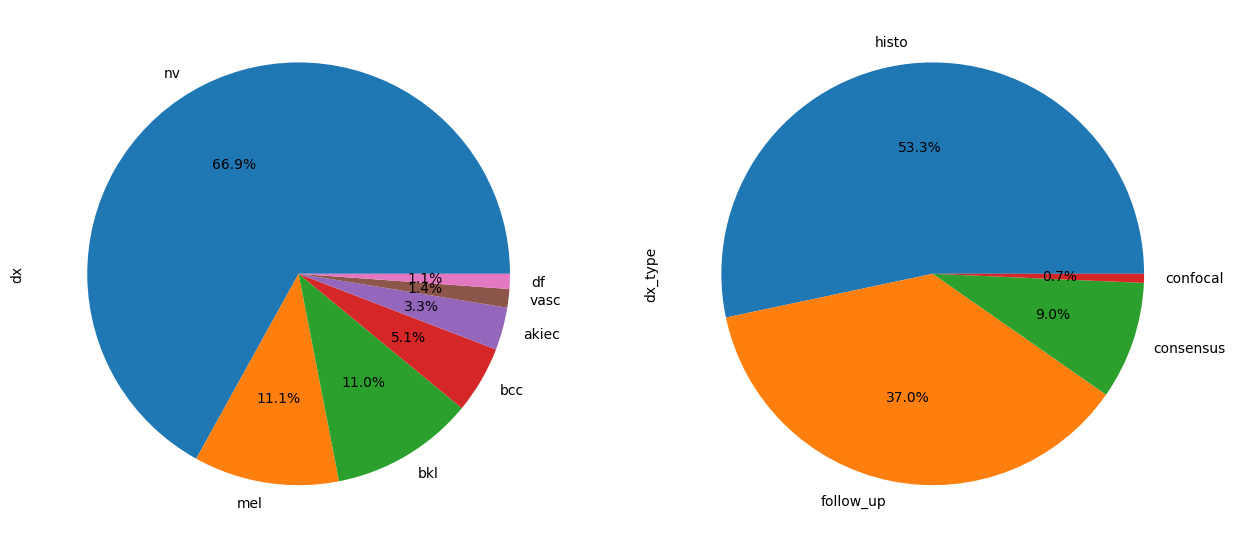

In [34]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
tile_df['dx'].value_counts().plot.pie(autopct="%1.1f%%")
plt.subplot(1,2,2)
tile_df['dx_type'].value_counts().plot.pie(autopct="%1.1f%%")
plt.show()

<AxesSubplot: title={'center': 'LOCALIZATION VS GENDER'}, xlabel='count', ylabel='localization'>

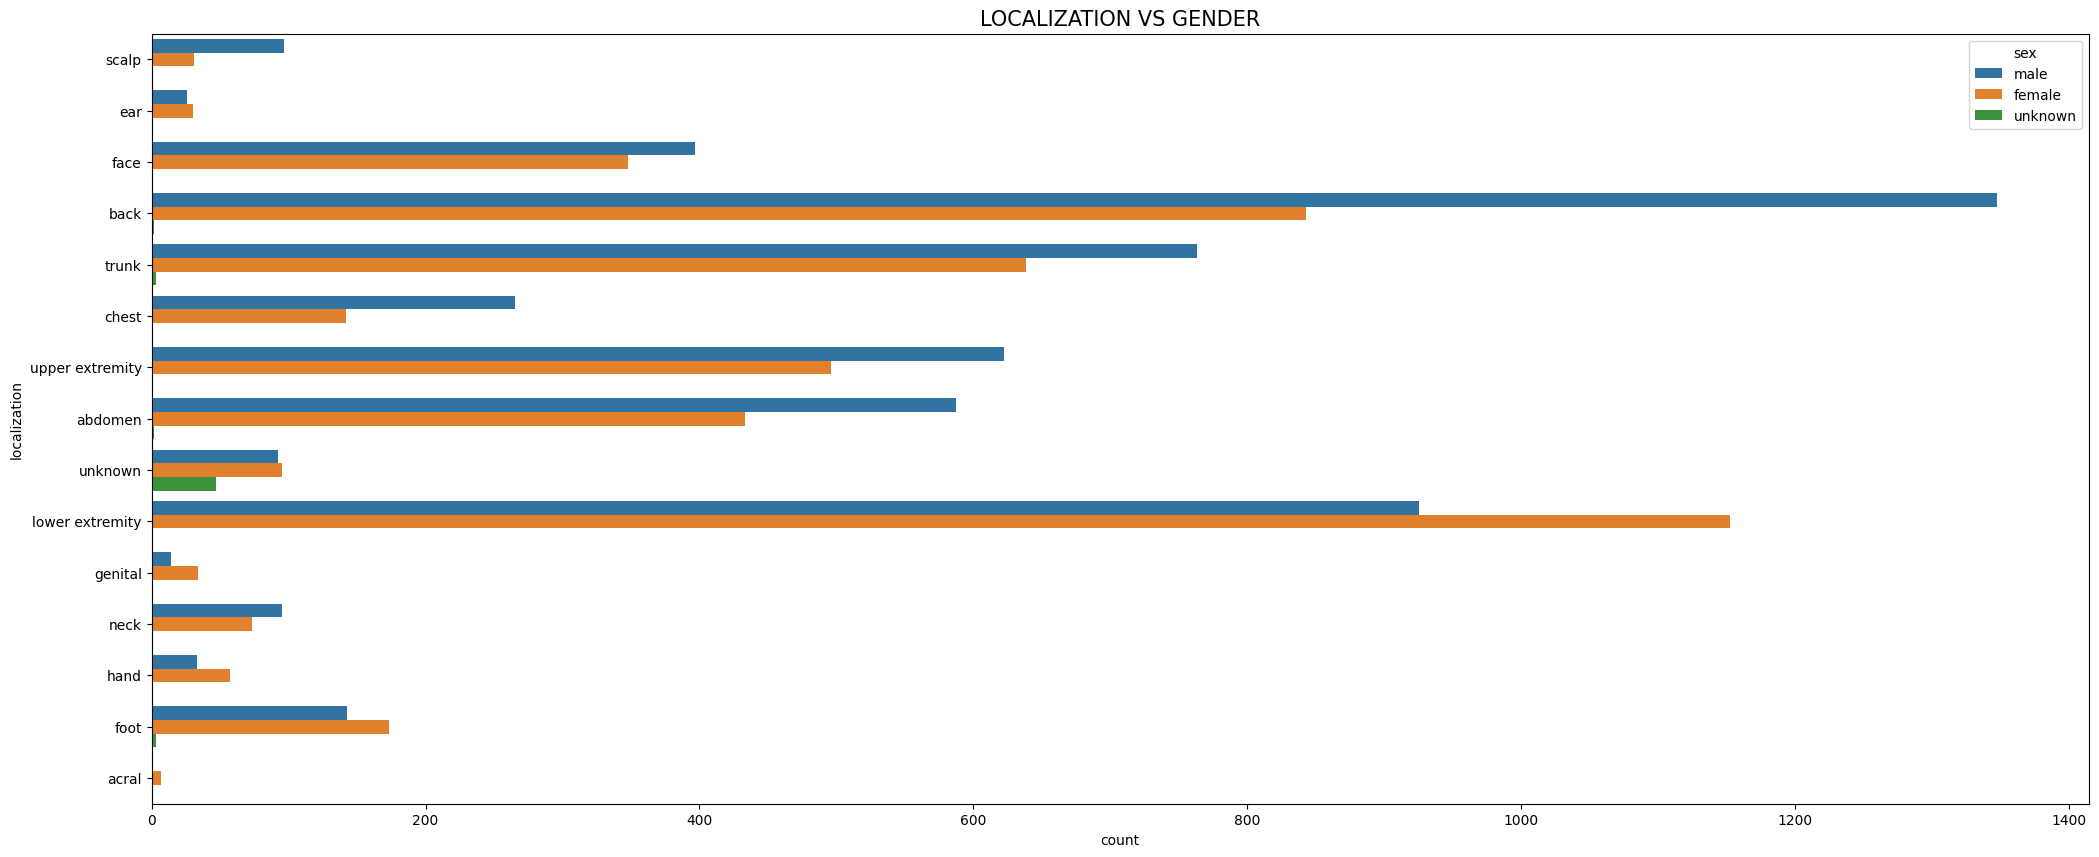

In [35]:
plt.figure(figsize=(25,10))
plt.title('LOCALIZATION VS GENDER',fontsize = 15)
sns.countplot(y='localization', hue='sex',data=tile_df)

<AxesSubplot: title={'center': 'LOCALIZATION VS CELL TYPE'}, xlabel='localization', ylabel='count'>

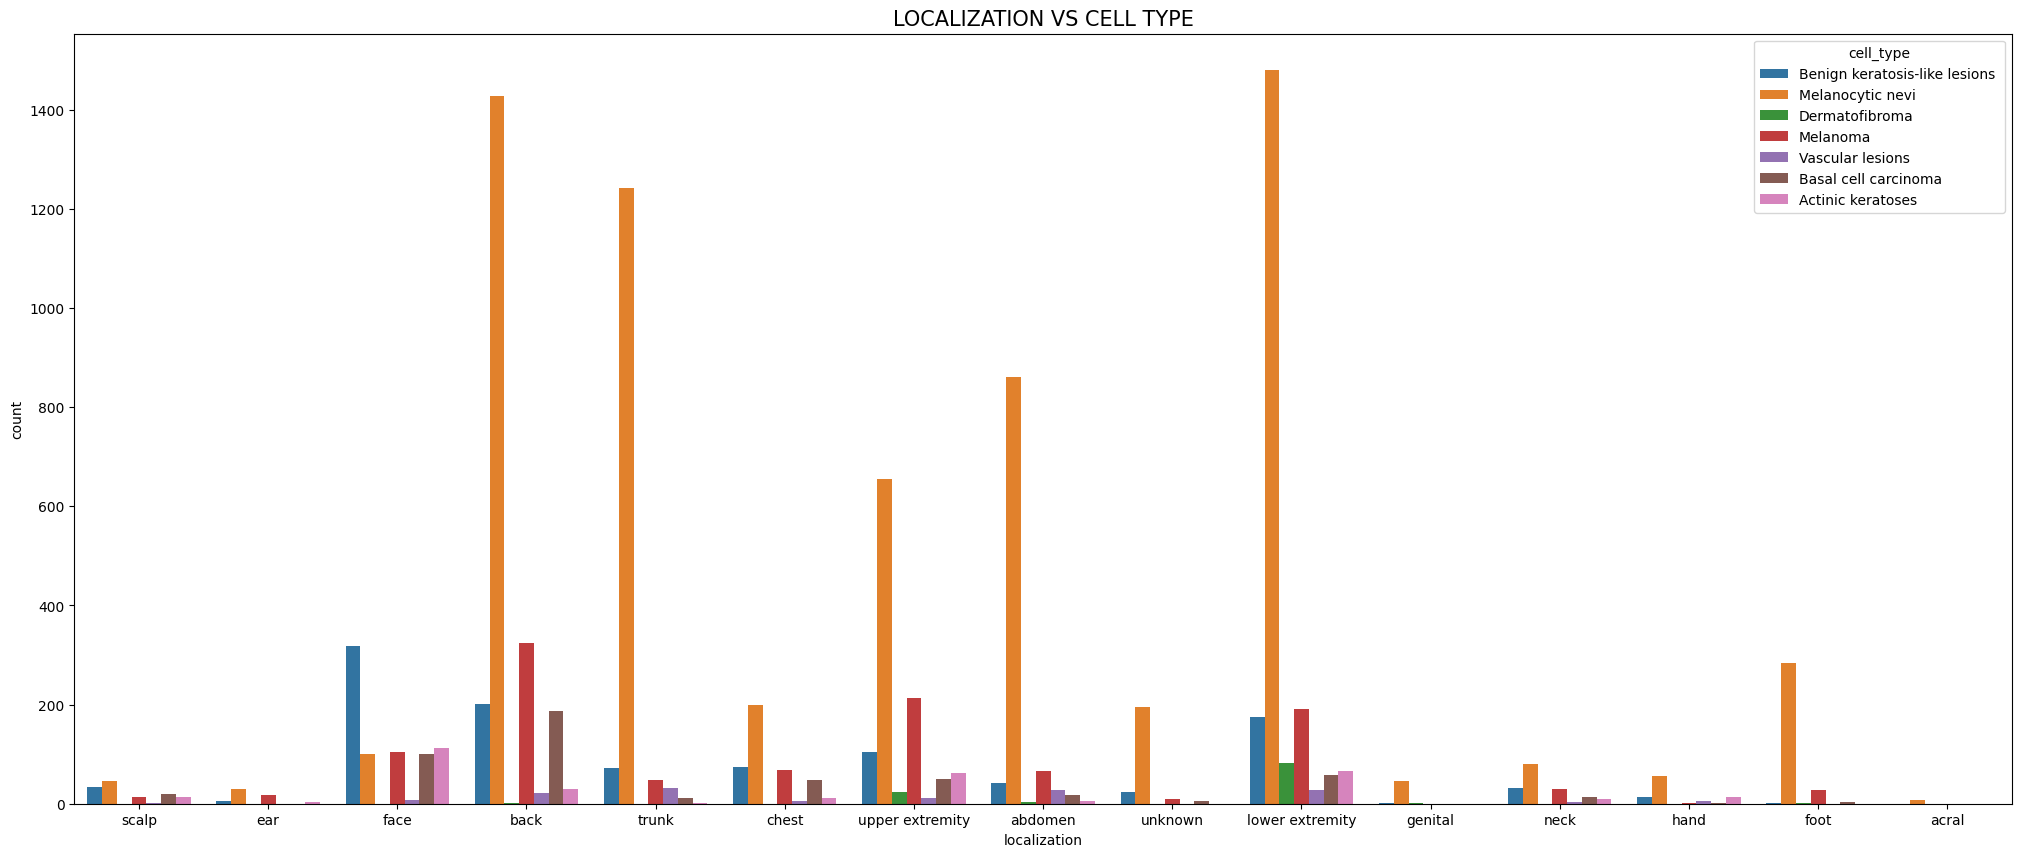

In [36]:
plt.figure(figsize=(25,10))
plt.title('LOCALIZATION VS CELL TYPE',fontsize = 15)
sns.countplot(x='localization', hue='cell_type',data=tile_df)

<AxesSubplot: title={'center': 'LOCALIZATION VS CELL TYPE'}, xlabel='cell_type', ylabel='count'>

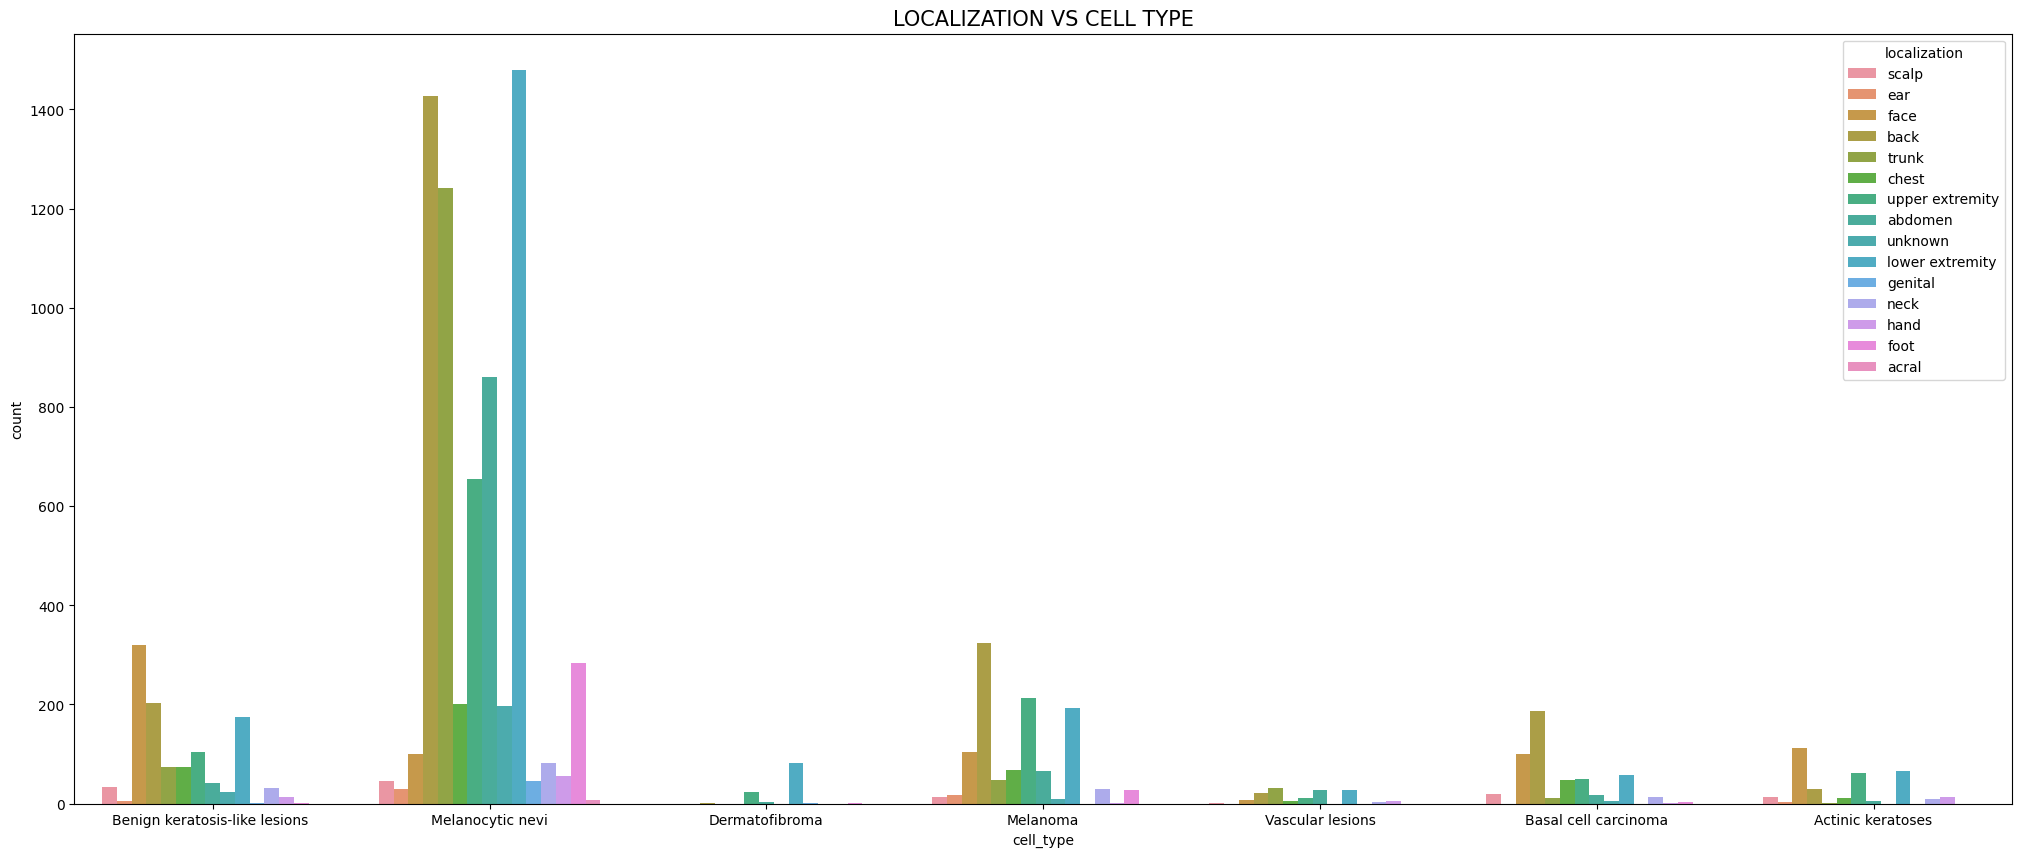

In [37]:
plt.figure(figsize=(25,10))
plt.title('LOCALIZATION VS CELL TYPE',fontsize = 15)
sns.countplot(x='cell_type', hue='localization',data=tile_df)

<AxesSubplot: title={'center': 'GENDER VS CELL TYPE'}, xlabel='count', ylabel='sex'>

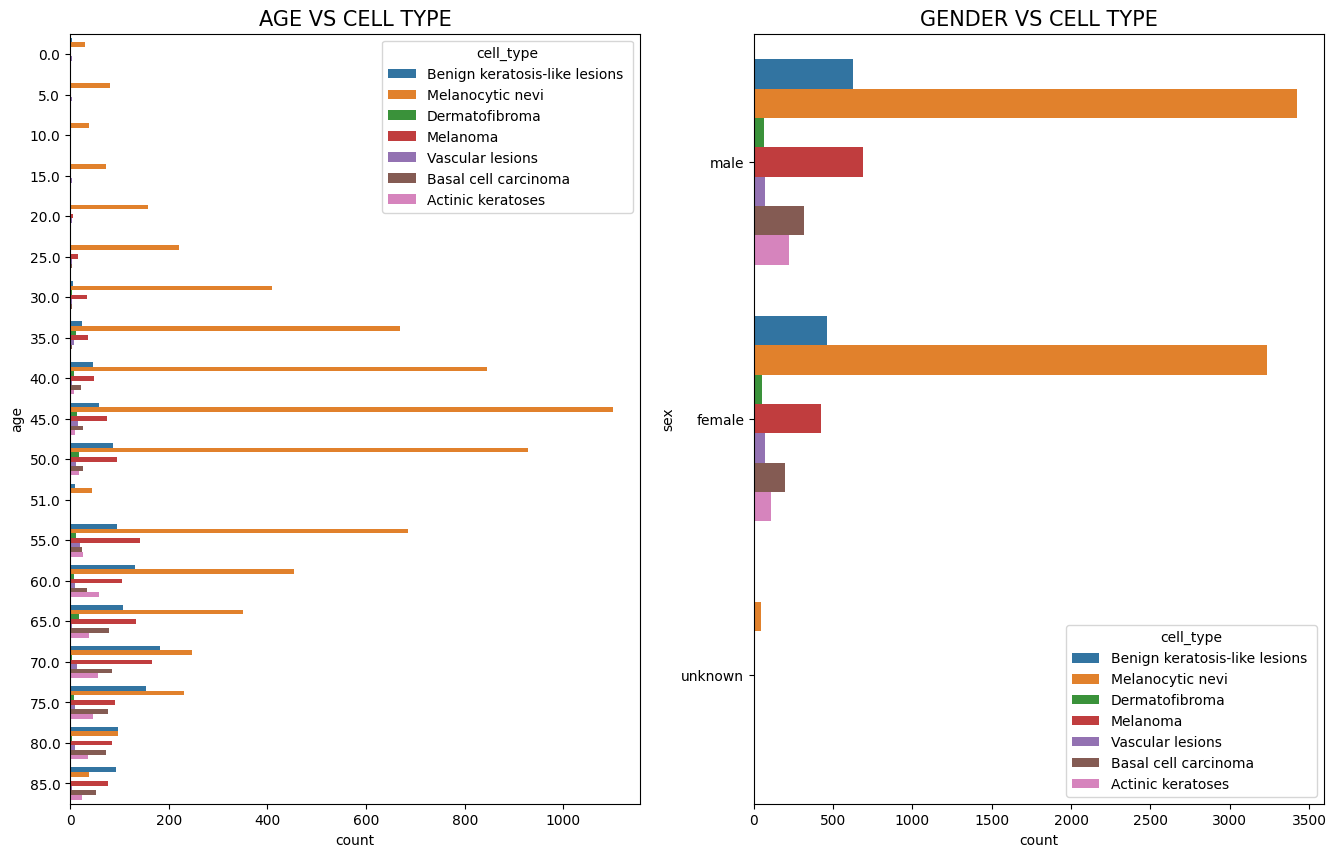

In [38]:
plt.figure(figsize=(25,10))
plt.subplot(131)
plt.title('AGE VS CELL TYPE',fontsize = 15)
sns.countplot(y='age', hue='cell_type',data=tile_df)
plt.subplot(132)
plt.title('GENDER VS CELL TYPE',fontsize = 15)
sns.countplot(y='sex', hue='cell_type',data=tile_df)

# ANN 

In [39]:
import pandas as pd
from sklearn.datasets import load_iris

In [40]:
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [41]:
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import to_categorical
from glob import glob

In [42]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}
NUM_IMAGES

1000

In [43]:
trial_data = tile_df.sample(2000)

In [44]:
features = trial_data.drop(['cell_type_idx'], axis = 1)
label = trial_data['cell_type_idx']

In [45]:
features.shape,label.shape

((2000, 10), (2000,))

In [46]:
x_train, x_test, y_train, y_test = train_test_split(features, label,
                                                    test_size=0.2, shuffle = True, random_state = 42)



In [47]:
print("X_train shape: {}".format(x_train.shape))
print("X_test shape: {}".format(x_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (1600, 10)
X_test shape: (400, 10)
y_train shape: (1600,)
y_test shape: (400,)


In [48]:
tf.unique(x_train.cell_type.values)

2022-11-15 02:16:01.118473: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-15 02:16:01.118518: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Unique(y=<tf.Tensor: shape=(7,), dtype=string, numpy=
array([b'Melanocytic nevi', b'Dermatofibroma', b'Vascular lesions',
       b'Benign keratosis-like lesions ', b'Melanoma',
       b'Basal cell carcinoma', b'Actinic keratoses'], dtype=object)>, idx=<tf.Tensor: shape=(1600,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 5, 3], dtype=int32)>)

In [49]:
x_train = np.asarray(x_train['image'].tolist())
x_test = np.asarray(x_test['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [50]:
x_train.shape

(1600, 224, 224, 3)

In [51]:
y_train = to_categorical(y_train, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)

y_test.shape, y_train.shape

((400, 7), (1600, 7))

In [52]:
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [53]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.25, random_state = 42)

In [54]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1] * x_train.shape[2] * x_train.shape[3])
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1] * x_test.shape[2] * x_test.shape[3])
x_val = x_val.reshape(x_val.shape[0],x_val.shape[1] * x_val.shape[2] * x_val.shape[3])
print(x_train.shape)
print(x_test.shape)


(1200, 150528)
(400, 150528)


In [55]:
x_val.shape

(400, 150528)

In [56]:
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(1200, 150528)
(400, 150528)
(400, 150528)
(1200, 7)
(400, 7)
(400, 7)


In [57]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [58]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("../skin-legion-deep-learning-project-/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [59]:
# Create early stopping (once our model stops improving, stop training)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3) # stops after

# MODEL 1

In [60]:
tf.random.set_seed(28)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(units= 16, kernel_initializer = 'uniform', activation = 'relu'),
    tf.keras.layers.Dense(units= 32, kernel_initializer = 'uniform', activation = 'relu'),
    tf.keras.layers.Dense(units= 64, kernel_initializer = 'uniform', activation = 'relu'),
    tf.keras.layers.Dense(units= 128, kernel_initializer = 'uniform', activation = 'relu'),
    #tf.keras.layers.Dense(units= 512, kernel_initializer = 'uniform', activation = 'relu'),
    tf.keras.layers.Dense(units = 7, kernel_initializer = 'uniform', activation = 'softmax')])

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001,
                                    beta_1 = 0.9,
                                    beta_2 = 0.999,
                                    epsilon = 1e-8)

# compile the keras model
model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy'])

# fit the keras model on the dataset
epochs = 100
history = model.fit(x_train,
                    y_train, 
                    batch_size = 100, 
                    epochs = epochs,
                    validation_data = (x_val,y_val)) #, # verbose = 0)


Epoch 1/100


2022-11-15 02:16:07.079579: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-15 02:16:08.122645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - ETA: 0s - loss: 1.4613 - accuracy: 0.6150

2022-11-15 02:16:09.790939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 3s 125ms/step - loss: 1.4613 - accuracy: 0.6150 - val_loss: 1.0561 - val_accuracy: 0.6950
Epoch 2/100
12/12 [==============================] - 1s 90ms/step - loss: 1.1035 - accuracy: 0.6608 - val_loss: 1.0171 - val_accuracy: 0.6950
Epoch 3/100
12/12 [==============================] - 1s 79ms/step - loss: 1.0448 - accuracy: 0.6608 - val_loss: 0.9990 - val_accuracy: 0.6950
Epoch 4/100
12/12 [==============================] - 1s 70ms/step - loss: 1.0111 - accuracy: 0.6608 - val_loss: 0.9579 - val_accuracy: 0.6950
Epoch 5/100
12/12 [==============================] - 1s 73ms/step - loss: 0.9691 - accuracy: 0.6617 - val_loss: 0.9407 - val_accuracy: 0.6825
Epoch 6/100
12/12 [==============================] - 1s 72ms/step - loss: 0.9357 - accuracy: 0.6567 - val_loss: 0.9275 - val_accuracy: 0.6875
Epoch 7/100
12/12 [==============================] - 1s 69ms/step - loss: 0.9363 - accuracy: 0.6592 - val_loss: 0.9323 - val_accuracy: 0.6950
Epoch 8/100
12/12

In [61]:
accuracy = model.evaluate(x_test, y_test, verbose=0)[1]
print("Test: accuracy = ",accuracy*100,"%")

2022-11-15 02:17:33.842690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test: accuracy =  60.749995708465576 %


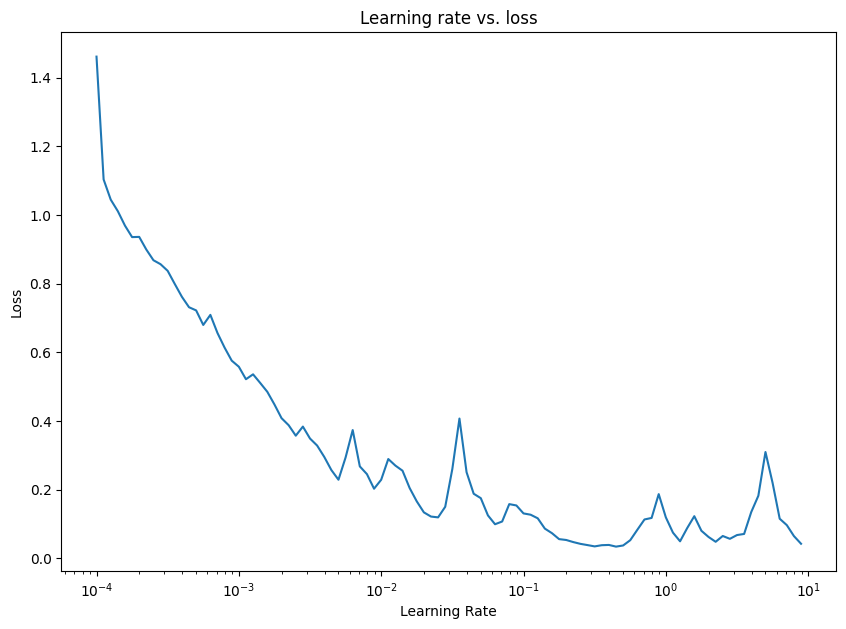

In [62]:
# Plot the learning rate versus the loss
lrs = 1e-4 * (10 ** (np.arange(epochs)/20))
plt.figure(figsize=(10, 7))
plt.semilogx(lrs, history.history["loss"]) # we want the x-axis (learning rate) to be log scale
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning rate vs. loss");

<AxesSubplot: title={'center': 'Rates'}>

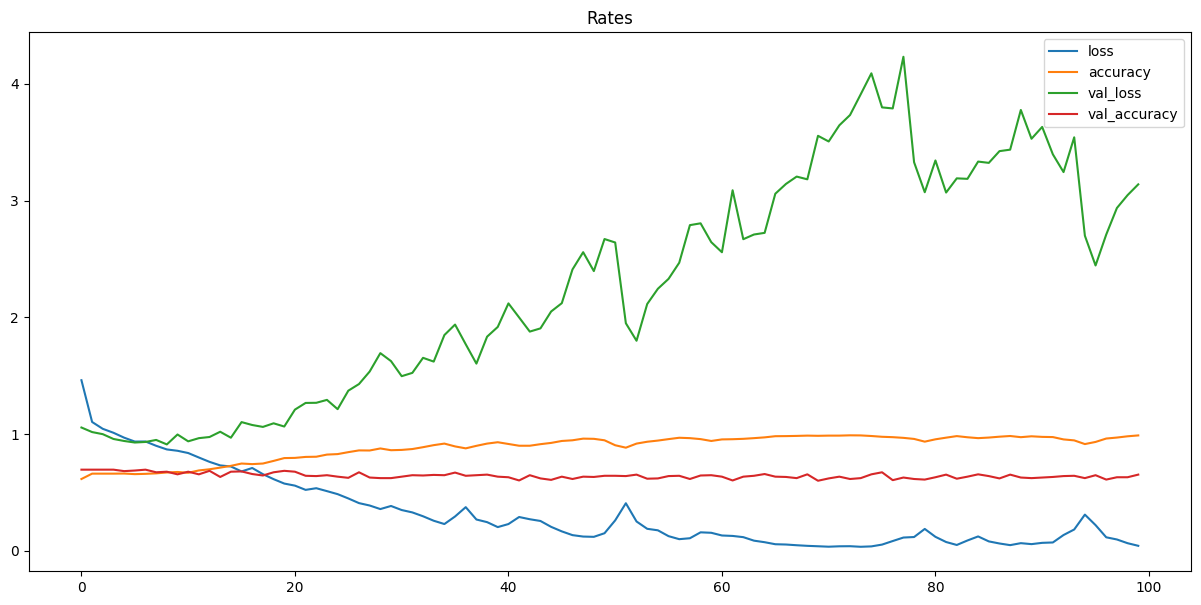

In [63]:
import pandas as pd
pd.DataFrame(history.history).plot(title='Rates', figsize=(15, 7))

In [65]:
tf.random.set_seed(22)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(units= 8, kernel_initializer = 'uniform', activation = 'relu'),
    tf.keras.layers.Dense(units= 16, kernel_initializer = 'uniform', activation = 'relu'),
    tf.keras.layers.Dense(units= 32, kernel_initializer = 'uniform', activation = 'relu'),
    tf.keras.layers.Dense(units= 64, kernel_initializer = 'uniform', activation = 'relu'),
    #tf.keras.layers.Dense(units= 512, kernel_initializer = 'uniform', activation = 'relu'),
    tf.keras.layers.Dense(units = 7, kernel_initializer = 'uniform', activation = 'softmax')])

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001,
                                    beta_1 = 0.9,
                                    beta_2 = 0.999,
                                    epsilon = 1e-8)

# compile the keras model
model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy'])

# fit the keras model on the dataset
history = model.fit(x_train,
                    y_train, 
                    batch_size = 100, 
                    epochs = 90,
                    callbacks=[early_stopping],
                    validation_data = (x_val,y_val)) #, # verbose = 0)

Epoch 1/90


2022-11-15 02:19:09.943217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 5s 353ms/step - loss: 1.6207 - accuracy: 0.6592 - val_loss: 1.1974 - val_accuracy: 0.6950
Epoch 2/90
 1/12 [=>............................] - ETA: 0s - loss: 1.1147 - accuracy: 0.6900

2022-11-15 02:19:14.004357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 1s 53ms/step - loss: 1.1531 - accuracy: 0.6608 - val_loss: 1.0946 - val_accuracy: 0.6950
Epoch 3/90
12/12 [==============================] - 0s 40ms/step - loss: 1.0791 - accuracy: 0.6608 - val_loss: 1.0073 - val_accuracy: 0.6950
Epoch 4/90
12/12 [==============================] - 0s 35ms/step - loss: 1.0437 - accuracy: 0.6608 - val_loss: 0.9841 - val_accuracy: 0.6950


# MODEL 2

In [66]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(units= 16, kernel_initializer = 'uniform', activation = 'relu'),
    tf.keras.layers.Dense(units= 32, kernel_initializer = 'uniform', activation = 'relu'),
    tf.keras.layers.Dense(units= 32, kernel_initializer = 'uniform', activation = 'relu'),
    tf.keras.layers.Dense(units= 64, kernel_initializer = 'uniform', activation = 'relu'),
    #tf.keras.layers.Dense(units= 512, kernel_initializer = 'uniform', activation = 'relu'),
    tf.keras.layers.Dense(units = 7, kernel_initializer = 'uniform', activation = 'softmax')])

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001,
                                    beta_1 = 0.9,
                                    beta_2 = 0.999,
                                    epsilon = 1e-8)

# compile the keras model
model1.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy'])

# fit the keras model on the dataset
epochs = 100
history1 = model1.fit(x_train,
                    y_train, 
                    batch_size = 100, 
                    epochs = epochs,
                    validation_data = (x_val,y_val)) #, # verbose = 0)

Epoch 1/100


2022-11-15 02:21:45.575679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - ETA: 0s - loss: 1.5523 - accuracy: 0.6083

2022-11-15 02:21:47.062669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 2s 131ms/step - loss: 1.5523 - accuracy: 0.6083 - val_loss: 1.1478 - val_accuracy: 0.6950
Epoch 2/100
12/12 [==============================] - 1s 94ms/step - loss: 1.1153 - accuracy: 0.6608 - val_loss: 1.0407 - val_accuracy: 0.6950
Epoch 3/100
12/12 [==============================] - 1s 84ms/step - loss: 1.0672 - accuracy: 0.6608 - val_loss: 1.0148 - val_accuracy: 0.6950
Epoch 4/100
12/12 [==============================] - 1s 78ms/step - loss: 1.0350 - accuracy: 0.6608 - val_loss: 0.9868 - val_accuracy: 0.6950
Epoch 5/100
12/12 [==============================] - 1s 78ms/step - loss: 1.0142 - accuracy: 0.6608 - val_loss: 0.9770 - val_accuracy: 0.6950
Epoch 6/100
12/12 [==============================] - 1s 79ms/step - loss: 0.9870 - accuracy: 0.6550 - val_loss: 0.9541 - val_accuracy: 0.6700
Epoch 7/100
12/12 [==============================] - 1s 79ms/step - loss: 0.9487 - accuracy: 0.6567 - val_loss: 0.9250 - val_accuracy: 0.6825
Epoch 8/100
12/12

In [67]:
accuracy1 = model.evaluate(x_test, y_test, verbose=0)[1]
print("Test: accuracy = ",accuracy1*100,"%")

2022-11-15 02:23:17.709809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test: accuracy =  65.49999713897705 %


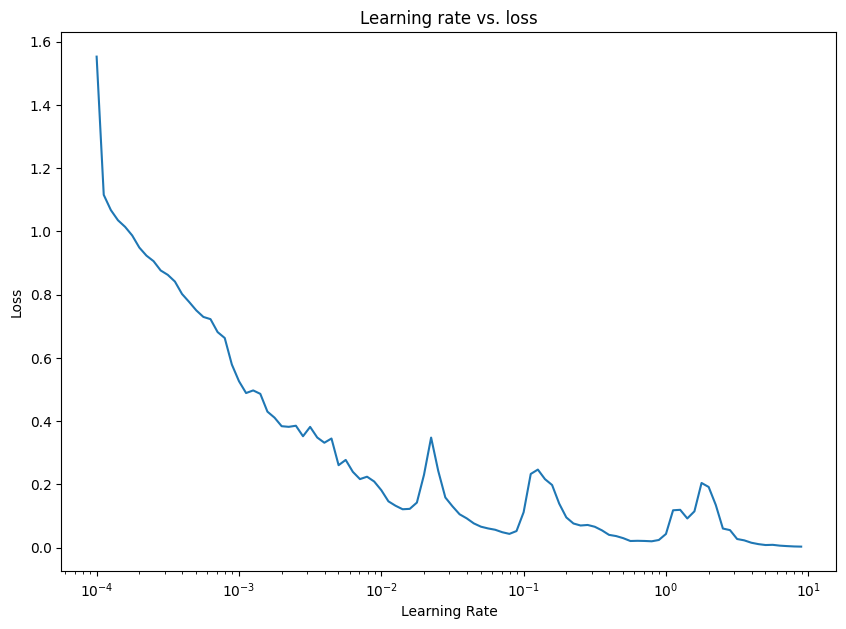

In [68]:
# Plot the learning rate versus the loss
lrs1 = 1e-4 * (10 ** (np.arange(epochs)/20))
plt.figure(figsize=(10, 7))
plt.semilogx(lrs1, history1.history["loss"]) # we want the x-axis (learning rate) to be log scale
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning rate vs. loss");

<AxesSubplot: title={'center': 'Rates'}>

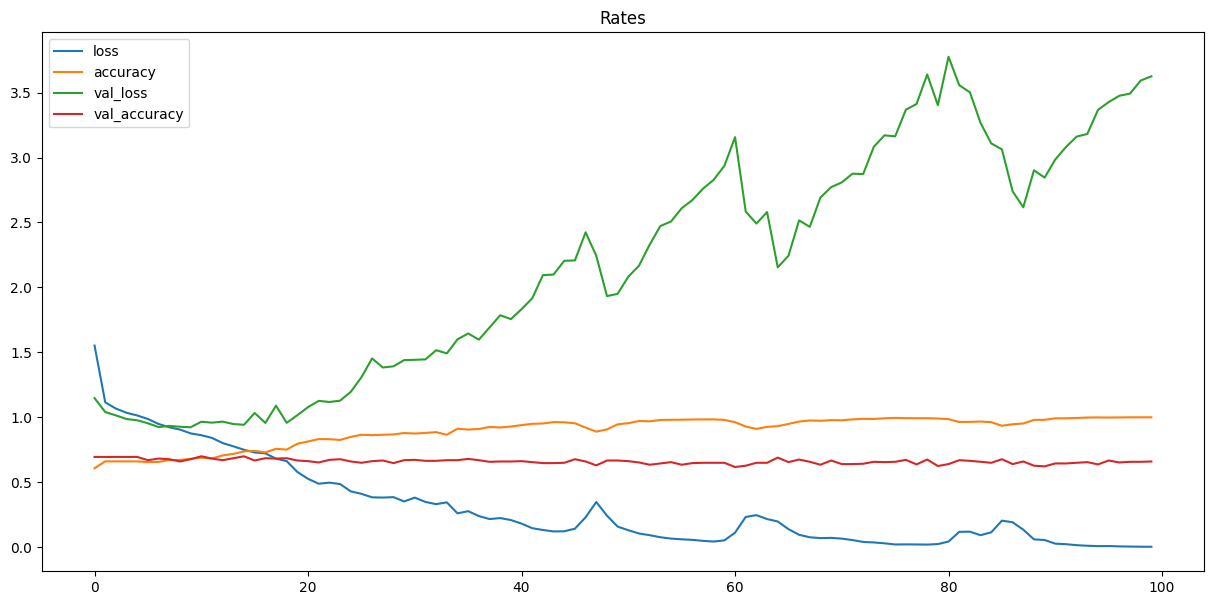

In [69]:
import pandas as pd
pd.DataFrame(history1.history).plot(title='Rates', figsize=(15, 7))

In [70]:
tf.random.set_seed(42)

model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(units= 32, kernel_initializer = 'uniform', activation = 'relu'),
    tf.keras.layers.Dense(units= 64, kernel_initializer = 'uniform', activation = 'relu'),
    tf.keras.layers.Dense(units= 128, kernel_initializer = 'uniform', activation = 'relu'),
    tf.keras.layers.Dense(units= 256, kernel_initializer = 'uniform', activation = 'relu'),
    tf.keras.layers.Dense(units = 7, kernel_initializer = 'uniform', activation = 'softmax')])

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00075,
                                    beta_1 = 0.9,
                                    beta_2 = 0.999,
                                    epsilon = 1e-8)

# compile the keras model
model1.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy'])

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10 ** (epoch/20))

# fit the keras model on the dataset
history1 = model1.fit(x_train, 
                      y_train, 
                      batch_size = 10, 
                      epochs = 65, 
                      verbose = 0,
                      callbacks = [lr_scheduler])

accuracy = model1.evaluate(x_val, y_val, verbose=0)[1]
print("Test: accuracy = ",accuracy*100,"%")



2022-11-15 02:23:20.401395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-15 02:25:10.109046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test: accuracy =  69.49999928474426 %


Text(0.5, 1.0, 'Finding the ideal learning rate')

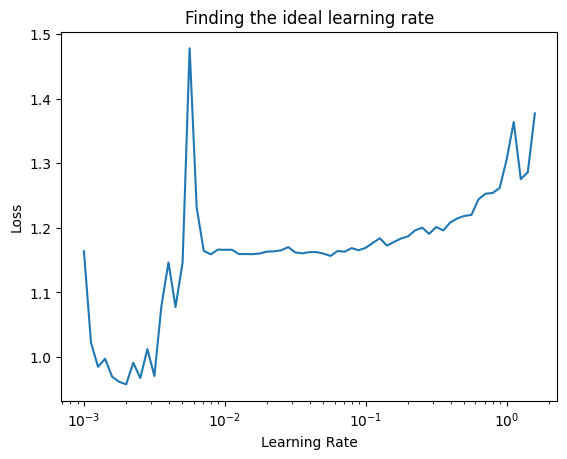

In [71]:
lrs = 1e-3 * (10**(tf.range(65)/20))
plt.semilogx(lrs,history1.history['loss'])
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Finding the ideal learning rate')

## MIKE Edits

In [72]:
from sklearn.utils import resample
import cv2
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import np_utils

# def balanced_dataset(df):
#     df_balanced = pd.DataFrame()
#     #df = pd.DataFrame()
    
#     for cat in df['cell_type_idx'].unique():
#         temp = resample(trial_data[trial_data['cell_type_idx'] == cat], 
#                         replace=True,     # sample with replacement
#                         n_samples=7000,   # to match majority class
#                         random_state=123) # reproducible results

#         # Combine majority class with upsampled minority class
#         df_balanced = pd.concat([df_balanced, temp])
 
#     df_balanced['cell_type'].value_counts()

#     return df_balanced

In [ ]:
# IMG_SIZE = 224
# # Setup input shape to the model
# INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# # Setup output shape of the model
# OUTPUT_SHAPE = 7 # number of unique labels

# # Setup model URL from TensorFlow Hub
# MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_035_224/classification/5"

In [ ]:
# def load_img_data(size, df, balanced=False):
#     """
#         ..
#         first we should normalize the image from 0-255 to 0-1
#     """
    
#     img_h, img_w = size, size
#     imgs = []
    
#     if balanced:
#         df = balanced_dataset(df)
    
#     image_paths = list(df['path'])

#     for i in tqdm(range(len(image_paths))):
#         img = cv2.imread(image_paths[i])
#         img = cv2.resize(img, (img_h, img_w))
#         img = img.astype(np.float32) / 255.
#         #img = np.asarray(Image.open(image_paths[i]).resize((size,size)))
#         imgs.append(img)

#     imgs = np.stack(imgs, axis=0)
#     print(imgs.shape)

#     #imgs = imgs.astype(np.float32) / 255.
    
#     return imgs, df['cell_type_idx'].values

In [ ]:
# imgs, target   = load_img_data(128, trial_data, balanced=False)

In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(imgs, target, test_size=0.20)
# x_train, x_val, y_train, y_val = train_test_split(imgs, target, test_size=0.05)

# train_val_test = (x_train, y_train, x_val, y_val, x_test, y_test)

# [x_train.shape, x_val.shape, x_test.shape]

In [ ]:
# class Tuner(object):

#     def __init__(self, data, architecture, hidden_layers, classes, epochs, batch_size):
#         self.input_shape = data[0][0].shape

#         self.base_arch = architecture
#         self.nn = self.download_network()
#         self.nn.trainable = False

#         self.hidden_layers = hidden_layers
        
#         self.classes = classes

#         self.trainX = data[0]
#         self.trainY = data[1]
#         self.valX = data[2]
#         self.valY = data[3]
#         self.testX = data[4]
#         self.testY = data[5]

#         self.EPOCHS = epochs
#         self.BATCH_SIZE = batch_size

#         self.model = self.build()
#         self.train_generator = self.data_augmentation()
#         self.predictions = None
#         self.score = None

#         self.best_weights = None

#     def download_network(self):
#         '''
#         Download the requested CNN with imagenet weights
#         '''
#         nn = None

#         if self.base_arch == 'VGG16':
#             nn = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=self.input_shape)
#         elif self.base_arch == 'VGG19':
#             nn = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=self.input_shape)
#         elif self.base_arch == 'InceptionV3':
#             nn = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=self.input_shape)
#         elif self.base_arch == 'Xception':
#             nn = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=self.input_shape)
#         elif self.base_arch == 'DenseNet121':
#             nn = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=self.input_shape)
#         elif self.base_arch == 'DenseNet201':
#             nn = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=self.input_shape)
#         elif self.base_arch == 'ResNet152V2':
#             nn = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=self.input_shape)
#         elif self.base_arch == 'MobileNet':
#             nn = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=self.input_shape)
#         elif self.base_arch == 'MobileNetV2':
#             nn = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=self.input_shape)

#         return nn

#     def run(self):
#         '''
#         Main driver for Learner object
#         '''
#         self.fine_tune()
#         #self.load_weights(self.best_weights)
#         #self.predict()

#     def build(self):
#         '''
#         Build model. Add Dense layer to topless base CNN.
#         '''

#         model = tf.keras.models.Sequential()
#         model.add(self.nn)
#         model.add(tf.keras.layers.Flatten())
#         model.add(tf.keras.layers.Dropout(0.25))
        
#         for layer in self.hidden_layers:
#             model.add(tf.keras.layers.Dense(layer, activation='relu'))
#             model.add(tf.keras.layers.BatchNormalization())
#             model.add(tf.keras.layers.Dropout(0.46))  

#         model.add(tf.keras.layers.Dense(self.classes, activation='softmax'))
        
#         print (model.summary())

#         return model

#     def load_weights(self, name):
#         '''
#         Load the best checkpointed weights.
#         '''
#         print('\nLoading best accuracy weights.')
#         self.model.load_weights(name)

#     def data_augmentation(self):
#         data_gen_args = dict(
#                 rotation_range=10,
#                 zoom_range=0.1,
#                 shear_range=0.1,
#                 width_shift_range=0.1, 
#                 height_shift_range=0.1,
#                 horizontal_flip=True,
#                 vertical_flip=True,
#             )

#         train_gen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
#         train_generator = train_gen.flow(self.trainX, self.trainY, batch_size=self.BATCH_SIZE)

#         #print('\nData augmentation with the following parameters:')
#         #pp.pprint(data_gen_args)

#         return train_generator

#     def get_class_weight(self):

#         weight_for_0 = (1 / (self.trainY == 0).sum())*(len(self.trainY))/7.0 
#         weight_for_1 = (1 / (self.trainY == 1).sum())*(len(self.trainY))/7.0
#         weight_for_2 = (1 / (self.trainY == 2).sum())*(len(self.trainY))/7.0 
#         weight_for_3 = (1 / (self.trainY == 3).sum())*(len(self.trainY))/7.0
#         weight_for_4 = (1 / (self.trainY == 4).sum())*(len(self.trainY))/7.0 
#         weight_for_5 = (1 / (self.trainY == 5).sum())*(len(self.trainY))/7.0
#         weight_for_6 = (1 / (self.trainY == 6).sum())*(len(self.trainY))/7.0

#         class_weight = {
#             0: weight_for_0, 
#             1: weight_for_1,
#             2: weight_for_2, 
#             3: weight_for_3,
#             4: weight_for_4, 
#             5: weight_for_5,
#             6: weight_for_6, 
#         }

#         print('Class_weights:\n', class_weight, '\n')
        
#         return class_weight

#     def fine_tune(self):
#         '''
#         Fine-tune network in 2 phases
#         '''

#         numTrainingSamples = self.trainX.shape[0]
#         numValidationSamples = self.valX.shape[0]

#         print ("\nPhase A - Training Fully Connected Layers\n")
#         self.model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])

#         # Define checkpoint to save best Phase 1 weights
#         best_weights_ph1 = self.base_arch + "_ph1_weights.hdf5"
#         checkpoint = tf.keras.callbacks.ModelCheckpoint(best_weights_ph1, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
        
#         history = self.model.fit(
#             x_train, y_train,
#             #self.train_generator,
#             steps_per_epoch=numTrainingSamples // self.BATCH_SIZE,
#             epochs=self.EPOCHS,
#             validation_data=(self.valX, self.valY),
#             validation_steps=numValidationSamples // self.BATCH_SIZE,
#             #class_weight=self.get_class_weight(),
#             callbacks=[checkpoint])
        
#         # Store the best phase 1 accuracy
#         best_acc_ph1 = max(history.history["val_accuracy"])
#         print('\n\nMax validation accuracy:', best_acc_ph1)

#         print('\nRestoring best weights and predicting validation set.')
#         self.load_weights(best_weights_ph1)

#         # Make predictions based on best phase 1 weights
#         self.predict()

#         self.plot_loss(history, self.EPOCHS, '\n Transfer Learning: ' + self.base_arch + ' Ph A')
        

#         print ("\nPhase B  - Fine Tune all Layers \n")
#         # Set full original CNN as trainable
#         self.nn.trainable = True

#         self.model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=1e-5), metrics=['accuracy'])

#         # Define checkpoint to save best Phase 2 weights
#         best_weights_ph2 = self.base_arch + "_ph2_weights.hdf5"
#         checkpoint = tf.keras.callbacks.ModelCheckpoint(best_weights_ph2, monitor="val_loss", mode="min", save_best_only=True, verbose=1)

#         # Fine-tune the full CNN + FC
#         history = self.model.fit(
#             x_train, y_train,
#             #self.train_generator,
#             steps_per_epoch=numTrainingSamples // self.BATCH_SIZE,
#             epochs=self.EPOCHS,
#             validation_data=(self.valX, self.valY),
#             validation_steps=numValidationSamples // self.BATCH_SIZE,
#             #class_weight=self.get_class_weight(),
#             callbacks=[checkpoint])

#         # Store the best phase 2 accuracy
#         best_acc_ph2 = max(history.history["val_accuracy"])
#         print('\n\nMax validation accuracy:', best_acc_ph2)

#         # Only if Phase 2 fine-tuning resulted in a better accuracy than phase 1,
#         # restore best phase 2 weights and update Tuner predictions.
#         if best_acc_ph2 > best_acc_ph1:
#             print('\nPhase 2 resulted in better accuracy than Phase 1.')
#             print('Restoring best weights of Ph2 and predicting validation set.')
#             self.load_weights(best_weights_ph2)
#             self.predict()

#         self.plot_loss(history, self.EPOCHS, '\n Transfer Learning: ' + self.base_arch + ' Ph B')
    
#     def predict(self):
#         '''
#         Get predictions and score for validation set.
#         '''
#         print('\nPredicting test set classes.')
#         self.score = self.model.evaluate(self.testX, self.testY, verbose=0)
#         print('Test set score:', self.score)
#         self.predictions = self.model.predict(self.testX, batch_size=self.BATCH_SIZE)
#         print('Done')

#     def plot_loss(self, history, epochs, name):
#         print('\n\n')
#         plt.figure(figsize=(12,8))
#         plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
#         plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")
#         plt.plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc")
#         # plt.plot(np.arange(0, epochs), history.history["val_accuracy"], label="val_acc")
#         plt.title("Training Loss and Accuracy - {}".format(name))
#         plt.xlabel("Epoch #")
#         plt.ylabel("Loss/Accuracy")
#         plt.legend()
#         plt.show()

In [ ]:
# NET = 'DenseNet201'
# HIDDEN_LAYERS = [512, 128]
# #HIDDEN_LAYERS = [256, 256, 64]
# CLASSES = len(set(target))
# BATCH_SIZE = 128
# EPOCHS = 10

# model = Tuner(train_val_test, NET, HIDDEN_LAYERS, CLASSES, EPOCHS, BATCH_SIZE)
# model.run()

In [ ]:
# model.predict()

In [ ]:
# # Function to plot confusion matrix    
# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Blues):
#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)

#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, cm[i, j],
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')


# # Predict the values from the validation dataset
# Y_pred = model.predictions
# # Convert predictions classes to one hot vectors 
# Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# # Convert validation observations to one hot vectors
# #Y_true = np.argmax(y_test,axis = 1) 
# # compute the confusion matrix
# confusion_mtx = confusion_matrix(y_test, Y_pred_classes)

 

# # plot the confusion matrix
# plot_confusion_matrix(confusion_mtx, classes = range(7))

In [ ]:
# # Create a function which builds a Keras model
# def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
#   print("Building model with:", MODEL_URL)

#   # Setup the model layers
#   model = tf.keras.Sequential([
#     hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
#     tf.keras.layers.Dense(units=OUTPUT_SHAPE, 
#                           activation="softmax") # Layer 2 (output layer)
#   ])

#   # Compile the model
#   model.compile(
#       loss=tf.keras.losses.CategoricalCrossentropy(), # Our model wants to reduce this (how wrong its guesses are)
#       optimizer=tf.keras.optimizers.Adam(), # A friend telling our model how to improve its guesses
#       metrics=["accuracy"] # We'd like this to go up
#   )

#   # Build the model
#   model.build(INPUT_SHAPE) # Let the model know what kind of inputs it'll be getting
  
#   return model

In [ ]:
# # Create a model and check its details
# model = create_model()
# model.summary()

In [ ]:
# How many rounds should we get the model to look through the data?
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [ ]:
# # Build a function to train and return a trained model
# def train_model():
#   """
#   Trains a given model and returns the trained version.
#   """
#   # Create a model
#   model = create_model()

#   # Create new TensorBoard session everytime we train a model
#   tensorboard = create_tensorboard_callback()

#   # Fit the model to the data passing it the callbacks we created
#   model.fit(x_train,
#             batch_size=32,
#             epochs=NUM_EPOCHS,
#             verbose=0,
#             validation_data=x_val,
#             validation_freq=1, # check validation metrics every epoch
#             callbacks=[tensorboard, early_stopping])
  
#   return model

In [ ]:

# # Fit the model to the data
# model = train_model()

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true,y_pred, classes = None, figsize = (10,10), text_size=15):
  cm = confusion_matrix(y_true,tf.round(y_pred))
  cm_norm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
  n_classes = cm.shape[0]

  # Making it pretty
  fig,ax = plt.subplots(figsize = figsize)
  cax = ax.matshow(cm,cmap=plt.cm.Blues)
  fig.colorbar(cax)

# Set labels to classes
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title = 'Confusion Matrix',
        xlabel = 'Predicted Label',
        ylabel= 'True Label',
        xticks = np.arange(n_classes),
        yticks = np.arange(n_classes),
        xticklabels = labels,
        yticklabels = labels)

  # Set x-axis labels to bottom
  ax.xaxis.set_label_position('bottom')
  ax.xaxis.tick_bottom()

  # Adjust label size
  ax.yaxis.label.set_size(text_size)
  ax.xaxis.label.set_size(text_size)
  ax.title.set_size(text_size)

  # Set threshold for different colors
  threshold = (cm.max() + cm.min())/2

  # Plot the text on each
  for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i, f"{cm[i,j]} ({cm_norm[i,j]*100:.1f}%)",
            horizontalalignment = 'center',
            color = 'white' if cm[i,j] > threshold else 'black',
            size = text_size)

In [ ]:
y_probs = model.predict(y_test) 
y_preds = y_probs .argmax(axis=1)

In [ ]:
class_names = ['Benign keratosis-like lesions ', 'Melanocytic nevi','Dermatofibroma', 
               'Melanoma', 'Vascular lesions','Basal cell carcinoma', 'Actinic keratoses']
make_confusion_matrix(y_true=y_test, 
                      y_pred = y_preds, 
                      classes = class_names,
                      figsize = (13,13),
                      text_size = 10)

# TRANSFER LEARNING

#CNN

In [ ]:
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization,Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
input_shape = (224, 224, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same'))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.16))

model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same'))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.20))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

In [ ]:
# Define the optimizer
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [ ]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)